In [20]:
import itertools
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from scipy.stats import pearsonr


sns.set_context("notebook")
sns.set_palette("colorblind")
sns.set_style("dark")

In [21]:
scores_df = pd.read_csv(Path(r"S:\E_ResearchData\evdplanner\CombinedGrades.csv"))
scores_df.head()

,PatientID,RaterID,Modality,Side,Score
0,Augmedit Other CTA_4,JD,CT,Left,1
1,Augmedit Other CTA_4,JD,CT,Right,1
2,Augmedit Other EVDSampleDICOM,JD,CT,Left,1
3,Augmedit Other EVDSampleDICOM,JD,CT,Right,1
4,Augmedit SAH_USZ 01700,JD,CT,Left,1


In [22]:
# Do a majority voting by RaterID
majority = scores_df.groupby(["PatientID", "Modality", "Side"])["Score"].agg(
    lambda x: x.value_counts().idxmax()
)
majority = majority.reset_index()

print(len(scores_df))
print(len(majority))

# Insert the majority voting into the original dataframe with rater ID "MAJ"
majority["RaterID"] = "Majority"
df = pd.concat([scores_df, majority], ignore_index=True)

print(len(df))
scores = df[df["RaterID"] == "Majority"]["Score"].value_counts()
total = scores.sum()
for score, count in scores.items():
    print(f"{score}: {count} ({count/total:.2%})")

294
98
392
1: 91 (92.86%)
3: 5 (5.10%)
2: 2 (2.04%)


In [23]:
graders = {idx: grader for idx, grader in enumerate(df["RaterID"].unique())}
pairs = itertools.combinations(graders.keys(), 2)

# Pearson correlation
print("Pearson correlation between graders:")
for a, b in pairs:
    a_scores = df.loc[df["RaterID"] == graders[a], "Score"]
    b_scores = df.loc[df["RaterID"] == graders[b], "Score"]
    corr, p = pearsonr(a_scores, b_scores)
    print(f"{graders[a]} and {graders[b]}: {corr:.2f} ({p:.4f})")

Pearson correlation between graders:
JD and TD: 0.57 (0.0000)
JD and MK: 0.61 (0.0000)
JD and Majority: 0.50 (0.0000)
TD and MK: 0.94 (0.0000)
TD and Majority: 0.90 (0.0000)
MK and Majority: 0.84 (0.0000)


Effect size: 0.0, Power: 0.106ion 1000/10000
Effect size: 0.05, Power: 0.111
Effect size: 0.1, Power: 0.123
Effect size: 0.15000000000000002, Power: 0.135
Effect size: 0.2, Power: 0.159
Effect size: 0.25, Power: 0.192
Effect size: 0.30000000000000004, Power: 0.228
Effect size: 0.35000000000000003, Power: 0.271
Effect size: 0.4, Power: 0.315
Effect size: 0.45, Power: 0.359
Effect size: 0.5, Power: 0.403
Effect size: 0.55, Power: 0.443
Effect size: 0.6000000000000001, Power: 0.480
Effect size: 0.65, Power: 0.514
Effect size: 0.7000000000000001, Power: 0.545
Effect size: 0.75, Power: 0.573
Effect size: 0.8, Power: 0.598
Effect size: 0.8500000000000001, Power: 0.620
Effect size: 0.9, Power: 0.640
Effect size: 0.9500000000000001, Power: 0.658
Effect size: 1.0, Power: 0.674


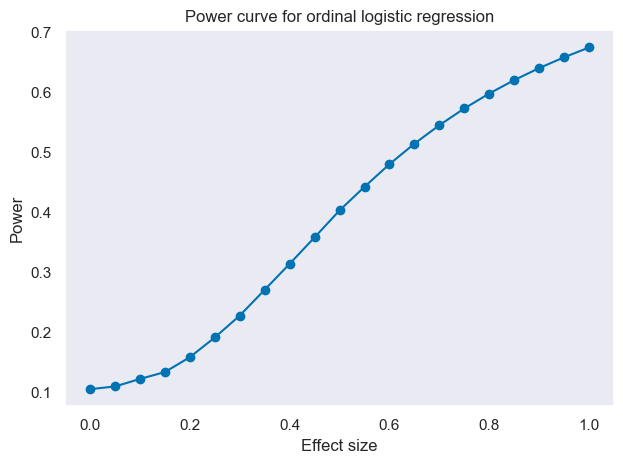

In [5]:
import numpy as np
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

# Parameters
n_simulations = 1000  # Number of simulations
n_mri = 50  # Number of MRI samples
n_ct = 48  # Number of CT samples
effect_sizes = np.linspace(0, 1, 21)  # Effect sizes to test
thresholds = [0, 1]  # Define thresholds between ordinal categories
significance_level = 0.05
num_categories = 3  # Number of ordinal categories (Kakarla score)
np.random.seed(42)  # Set seed for reproducibility

# Total sample size
n_samples = n_mri + n_ct

# Placeholder for storing p-values
p_values = []
effects = []

# Simulating the data and running the model in a loop
for effect_size in effect_sizes:
    for sim in range(n_simulations):
        print(f"ES {effect_size}: Simulation {sim + 1}/{n_simulations}", end="\r")
        # Simulate Modality variable with imbalance (1 = MRI, 0 = CT)
        modality = np.concatenate([np.ones(n_mri), np.zeros(n_ct)])

        # Simulate Side variable (0 = Left, 1 = Right)
        side = np.array([0, 1] * n_samples)

        # Shuffle the data
        p = np.random.permutation(n_samples)
        modality = modality[p]
        side = side[p]

        # Simulate the latent variable as a linear combination of the predictors + noise
        latent = (
            effect_size * modality + effect_size * side + np.random.normal(0, 1, size=n_samples)
        )

        # Convert latent variable to ordinal categories using thresholds
        y = np.digitize(latent, thresholds)

        # Create a DataFrame
        df_sim = pd.DataFrame({"Modality": modality, "Side": side, "Kakarla_score": y})

        # Fit the ordinal logistic regression model
        model = OrderedModel(df_sim["Kakarla_score"], df_sim[["Modality", "Side"]], distr="logit")
        results = model.fit(disp=False)

        # Extract p-value for the main effects (Modality, Side)
        p_value_modality = results.pvalues["Modality"]
        p_value_side = results.pvalues["Side"]

        # Check if either p-value is significant
        p_values.append(min(p_value_modality, p_value_side))

    # Calculate the proportion of significant p-values
    power_estimate = np.mean(np.array(p_values) < significance_level)

    effects.append((effect_size, power_estimate))

for effect_size, power in effects:
    print(f"Effect size: {effect_size}, Power: {power:.3f}")

# Plot the power curve
effects, powers = zip(*effects)
plt.plot(effects, powers, marker="o")
plt.xlabel("Effect size")
plt.ylabel("Power")
plt.title("Power curve for ordinal logistic regression")
plt.tight_layout()
plt.show()

In [24]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

# Ordinal Logistic Regression
majority["Score"] = majority["Score"].astype("category").cat.codes
majority["Modality"] = majority["Modality"].astype("category").cat.codes
majority["Side"] = majority["Side"].astype("category").cat.codes

majority["interactions"] = majority["Modality"] * majority["Side"]

y = majority["Score"]
X = majority[["Modality", "Side", "interactions"]]

sm.add_constant(X)

model = OrderedModel(y, X, distr="logit")
results = model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.297326
         Iterations: 346
         Function evaluations: 564
                             OrderedModel Results                             
Dep. Variable:                  Score   Log-Likelihood:                -29.138
Model:                   OrderedModel   AIC:                             68.28
Method:            Maximum Likelihood   BIC:                             81.20
Date:                Tue, 04 Feb 2025                                         
Time:                        15:20:12                                         
No. Observations:                  98                                         
Df Residuals:                      93                                         
Df Model:                           3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------

In [26]:
print(graders)

{0: 'JD', 1: 'TD', 2: 'MK', 3: 'Majority'}


<Axes: xlabel='PatientID', ylabel='Score'>

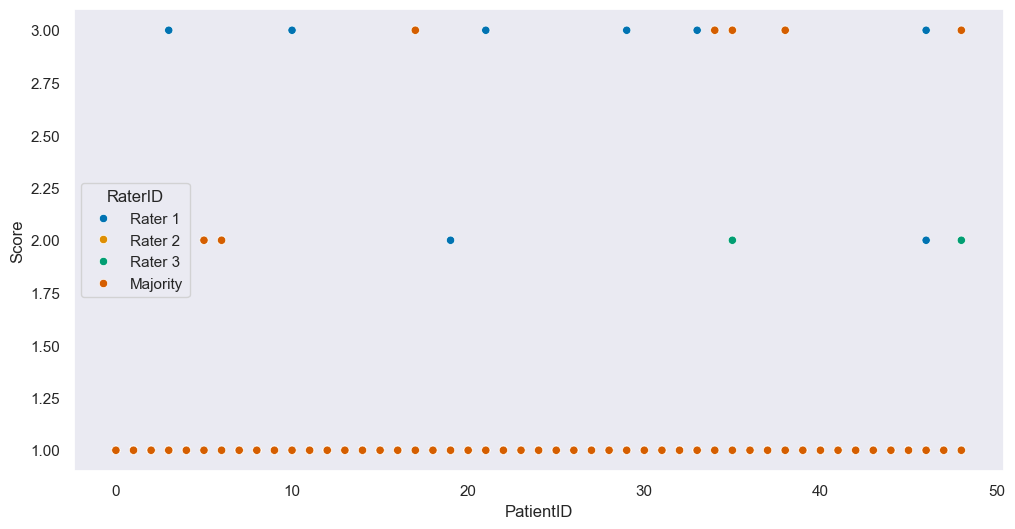

In [60]:
anon_df = df.copy()
anon_df["RaterID"] = anon_df["RaterID"].apply(
    lambda x: f"Rater {list(graders.values()).index(x) + 1}" if x != "Majority" else "Majority"
)
anon_df["PatientID"] = anon_df["PatientID"].factorize()[0]

fig, ax = plt.subplots(figsize=(12, 6))

sns.scatterplot(
    data=anon_df,
    x="PatientID",
    y="Score",
    hue="RaterID",
    # multiple="stack",
    # stat="count",
    ax=ax,
)

Score
1    91
3     5
2     2
Name: count, dtype: int64
[91  5  2]
['Kakarla 1', 'Kakarla 3', 'Kakarla 2']


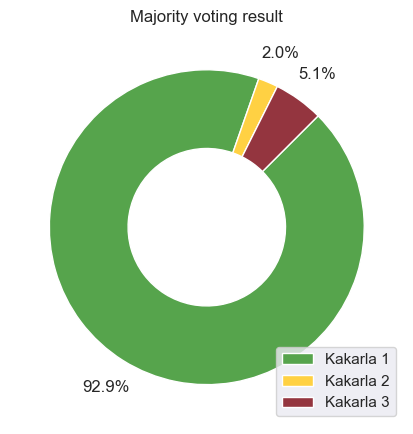

In [72]:
majority_count = anon_df.loc[anon_df["RaterID"] == "Majority", "Score"].value_counts()
print(majority_count)

values = majority_count.values
labels = [f"Kakarla {x}" for x in majority_count.index]

print(values)
print(labels)

# Sort by label name
values, labels = zip(*sorted(zip(values, labels), key=lambda x: x[1]))

plt.figure(figsize=(4.5, 4.5))
plt.pie(
    x=values,
    autopct="%1.1f%%",
    pctdistance=1.2,
    startangle=45,
    counterclock=False,
    wedgeprops={
        "width": 0.5,
    },
    colors=[
        "#56A44C",
        "#FFD143",
        "#94353F",
    ],
)
plt.legend(labels, loc="lower right")
plt.title("Majority voting result")
plt.tight_layout()
plt.show()